
# Watershed Dynamics Model 

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:300px;padding:20px">   

Here we explore recharge-driven shallow landsliding in the North Cascades National Park Complex (NOCA) from a HydroShare Observatory. 

This Jupyter Notebook runs the Landlab LandslideProbability component on a 30-m digital elevation model (DEM) for NOCA using recharge from Variable Infiltration Capacity (VIC) hydrologic model as described in the paper: <br />
#### Strauch et al. 2018. A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6, 1-26. <br />

This notebook performs the following functions to replicate the paper findings:<br >
1) Import libraries and set HydroShare variables<br />
2) Review data needed as input for the landslide model<br />
3) Create a RasterModelGrid based on a 30-m DEM<br />
4) Access and assign data fields used to calculate landslide probability<br />
5) Set Number of iterations to run Monte Carlo simulation<br />
6) Specify recharge option as _data driven spatial_ and access Python dictionaries to generate recharge distributions<br /> 
7) Run Landlab LandslideProbability component<br /> 
8) Display and visualize results of stability analysis<br /> 
<br /> 


## To run this notebook:

To run this example, click in each shaded cell below and "shift + enter" to run each cell. Alternatively, you can run groups of cells by clicking "Cell" on the menu above and selecting you run option. This is also where you can clear outputs from previous runs.

If an error occurs, try "Restart" the kernel by clicking "Kernel" on the menu above.

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading. and creation. Additional libraries support the functions of Landlab.

### Import libraries

In [1]:
#import Python utilities for calculating and plotting
import six
import os
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cPickle as pickle

#import utilities for importing and exporting to HydroShare
from utilities import hydroshare
# set variables for interacting with HydroShare from this notebook
hs=hydroshare.hydroshare()
# Create object to map the home directory
homedir = r'/home/jovyan/work/notebooks/data/' + str(os.environ["HS_RES_ID"]) + '/' + str(os.environ["HS_RES_ID"]) + '/data/contents/'
print homedir

# Import Landlab libraries
import landslide_probability
from landslide_probability import LandslideProbability
from landlab import imshow_grid_at_node
# from landlab.plot.imshow import imshow_node_grid
from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii
from collections import defaultdict

Adding the following system variables:
   HS_USR_NAME = RStrauch
   HS_RES_ID = 27d34fc967be4ee6bc1f1ae92657bf2b
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => RStrauch
Successfully established a connection with HydroShare
/home/jovyan/work/notebooks/data/27d34fc967be4ee6bc1f1ae92657bf2b/27d34fc967be4ee6bc1f1ae92657bf2b/data/contents/


/opt/conda/envs/python2/lib/python2.7/site-packages/landlab/__init__.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/envs/python2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/opt/conda/envs/python2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/kernelapp.py",

If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon in upper rigth corner to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

### Import data
 This data was preprocessed for the North Cascades National Park Complex case study and is on HydroShare as [Regional landslide hazard using Landlab - NOCA Data](https://www.hydroshare.org/resource/a5b52c0e1493401a815f4e77b09d352b/). Click on the link to see the data repository on HydroShare.

Set a variable name for the data resource using the HydroShare resource ID.

In [2]:
Data_ResourceID='a5b52c0e1493401a815f4e77b09d352b'

Execute the next cell to download data from another HydroShare resource - this may take a minute.

In [3]:
hs.getResourceFromHydroShare(Data_ResourceID)
data_folder = '/home/jovyan/work/notebooks/data/'+ Data_ResourceID +'/'+Data_ResourceID+'/data/contents/Data files/'
print('This is the location on the HydroShare JupyterHub server where the data has just been downloaded:')
print data_folder

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? Y
Download Finished                               
Successfully downloaded resource a5b52c0e1493401a815f4e77b09d352b


This is the location on the HydroShare JupyterHub server where the data has just been downloaded:
/home/jovyan/work/notebooks/data/a5b52c0e1493401a815f4e77b09d352b/a5b52c0e1493401a815f4e77b09d352b/data/contents/Data files/


 ## 2. Review data needed as input for the landslide model


Check the list of data inputs that the component needs.

In [4]:
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

Review the details of what each variable represents.

In [5]:
LandslideProbability._var_doc

{'landslide__probability_of_failure': 'number of times FS is <=1 out of number of iterations user selected',
 'soil__density': 'wet bulk density of soil',
 'soil__internal_friction_angle': 'critical angle just before failure due to friction between particles',
 'soil__maximum_total_cohesion': 'maximum of combined root and soil cohesion at node',
 'soil__mean_relative_wetness': 'Indicator of soil wetness; relative depth perched water table within the soil layer',
 'soil__minimum_total_cohesion': 'minimum of combined root and soil cohesion at node',
 'soil__mode_total_cohesion': 'mode of combined root and soil cohesion at node',
 'soil__probability_of_saturation': 'number of times relative wetness is >=1 out of number of iterations user selected',
 'soil__saturated_hydraulic_conductivity': 'mode rate of water transmitted through soil - provided if transmissivity is NOT provided to calculate tranmissivity  with soil depth',
 'soil__thickness': 'soil depth to restrictive layer',
 'soil__tr

Check the units of each variable.

In [6]:
LandslideProbability._var_units

{'landslide__probability_of_failure': 'None',
 'soil__density': 'kg/m3',
 'soil__internal_friction_angle': 'degrees',
 'soil__maximum_total_cohesion': 'Pa or kg/m-s2',
 'soil__mean_relative_wetness': 'None',
 'soil__minimum_total_cohesion': 'Pa or kg/m-s2',
 'soil__mode_total_cohesion': 'Pa or kg/m-s2',
 'soil__probability_of_saturation': 'None',
 'soil__saturated_hydraulic_conductivity': 'm/day',
 'soil__thickness': 'm',
 'soil__transmissivity': 'm2/day',
 'topographic__slope': 'tan theta',
 'topographic__specific_contributing_area': 'm'}

Now we will establish a RasterModelGrid based on a DEM for assigning our variables to.
Nodes are the center point of grid cells or pixels that are 30 m by 30 m in this example. 

## 3. Create a RasterModelGrid based on a 30-m DEM

#### Load  landslide model inputs from ASCII textfile (ArcGIS raster conversion) into Landlab grid

Load DEM elevation grid<br />
Set_nodata_nodes_to_inactive that have no data (e.g., -9999), which establishes boundary conditions<br />
This might take a few minutes as the park is large (2,757 km2).

In [7]:
(grid, z) = read_esri_ascii(data_folder+'/elevation.txt',name='topographic__elevation')
grid.at_node.keys()     # loads DEM grid with elevation
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], -9999) # set boundary conditions closed where no data

Confirm the size of the grid, nodes located every 30 m.

In [8]:
grid.number_of_nodes

7029145

Now we will attach data to this grid

## 4. Access and assign data fields to grid used to calculate landslide probability and set boundary conditions

#### For each input below
1. Load data from ascii text file
2. Assign grid to Landlab node
3. Set boundary conditions

For the eSurf paper with NOCA extent, this takes ~60 sec to load each file on NCSA ROGER super computer. 

Load slope


In [9]:
(grid1, slope) = read_esri_ascii(data_folder+'/slope_tang17d.txt')
grid.add_field('node', 'topographic__slope', slope)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__slope'], -9999)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__slope'], 0.0)

Load contributing area

In [10]:
(grid1, ca) = read_esri_ascii(data_folder+'/cont_area.txt')
grid.add_field('node', 'topographic__specific_contributing_area', ca)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__specific_contributing_area'], -9999)

Load transmissivity

In [11]:
(grid1, T) = read_esri_ascii(data_folder+'/transmis.txt')
grid.add_field('node', 'soil__transmissivity', T)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__transmissivity'], -9999)

Load cohesion (mode, min, and max) - this takes ~3 minutes because 3 cohesion fields are provided to create more flexibility in how cohesion is distributed on the landscape.

In [12]:
(grid1, C) = read_esri_ascii(data_folder+'/cohesion_mode.txt')
C[C == 0.0] = 1.0  # ensure minimum is >0 Pa for use in distributions generation
grid.add_field('node', 'soil__mode_total_cohesion', C)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__mode_total_cohesion'], -9999)

(grid1, C_min) = read_esri_ascii(data_folder+'/cohesion_min.txt')
grid.add_field('node', 'soil__minimum_total_cohesion', C_min)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__minimum_total_cohesion'], -9999)

(grid1, C_max) = read_esri_ascii(data_folder+'/cohesion_max.txt')
grid.add_field('node', 'soil__maximum_total_cohesion', C_max)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__maximum_total_cohesion'], -9999)

Load internal angle of friction

In [13]:
(grid1, phi) = read_esri_ascii(data_folder+'/frict_angle.txt')
grid.add_field('node', 'soil__internal_friction_angle', phi)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__internal_friction_angle'], -9999)

Set soil density value and assign to all nodes as a constant

In [14]:
grid['node']['soil__density'] = 2000*np.ones(grid.number_of_nodes)

Load soil thickness or depth

In [15]:
(grid1, hs) = read_esri_ascii(data_folder+'/soil_depth.txt')
grid.add_field('node', 'soil__thickness', hs)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__thickness'], -9999)

Load analysis mask and actual landslide

In [16]:
(grid1, mask) = read_esri_ascii(data_folder+'/exclud_mask.txt')
grid.add_field('node', 'exclusion_mask', mask)
grid.set_nodata_nodes_to_closed(grid.at_node['exclusion_mask'], -9999)

Load observed landslide inventory. Class 1-5 are landslides, 8 is no landslide mapped for later plotting

In [17]:
(grid1, slides) = read_esri_ascii(data_folder+'/landslide_type.txt')
grid.add_field('node', 'landslides', slides)

array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

## 6. Specify recharge option as _data driven spatial_ and access Python dictionaries to generate recharge distributions 

Recharge is this model represents the annual maximum recharge in mm/day. This corresponds to the wettest conditions expected annually, which is the severest soil-saturated conditions likely to occur at least once a year. 

Specify distribution to use in simulation

In [18]:
distribution = 'data_driven_spatial'

Load pre-processed routed flows dictionaries containing HSD_id and fractional drainage at each node and recharge dictionaries.  HSD is the Hydrologic Source Domain, which is the VIC data in this case study at ~5x6 km2 grid size.  The 'pickle' utility loads existing dictionaries.

In [19]:
# dict of node id (key) and HSD_ids (values)
HSD_id_dict = pickle.load(open(data_folder+'/dict_uniq_ids.p', 'rb'))
# dict of node id (key) and fractions (values)
fract_dict = pickle.load(open(data_folder+'/dict_coeff.p', 'rb'))
# dict of HSD id (key) with arrays of recharge (values)
HSD_dict = pickle.load(open(data_folder+'/HSD_dict.p', 'rb'))


Combine dictionaries into __ordered__ parameters required for _data driven spatial_ distribution

In [20]:
HSD_inputs = [HSD_dict,HSD_id_dict, fract_dict]

## 5. Set Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety index values using a Monte Carlo simulation, which randomly selects input values from parameter distributions. You can specify the number of iterations to run Monte Carlo simulation, but the default is 250. The higher the number of iteration, the longer the program runs, but the more precise the probability of failure results become.

In [21]:
iterations = 3000

## 7. Run the Landlab LandslideProbability Component

To run the landslide model, we first instantiate the LandslideProbability component with the above parameters, as well as the grid and number of iterations we specified before. Instantiate creates an instance of a class. (For example, the iPhone is a class and each phone is an instance.)

No outputs are generated by this command as it is setting up the recharge and instantiating the component.

In [22]:
LS_prob = LandslideProbability(grid,
    number_of_iterations=iterations,
    groudwater__recharge_distribution=distribution,
    groudwater__recharge_HSD_inputs=HSD_inputs)

Once the component has been instantiated, we generate outputs from running the component by calling the component's 'calculate_landslide_probability' method using the class instance (e.g., LS_prob). The following cell runs the model; in the following section we will assessing the results. These calculations will take a few minutes given the size of the modeling domain represented by core nodes.

In [23]:
LS_prob.calculate_landslide_probability()
print('Landslide probability successfully calculated')

Landslide probability successfully calculated


The outputs of landslide model simulation are:

In [24]:
sorted(LS_prob.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__probability_of_saturation']

Save the arrays as variables by 'attaching the fields to the grid' and view the outputs. **component already does this**

This simulation generates a probability value for each core node. 

In [25]:
LS_prob_probability_of_failure = grid.at_node['landslide__probability_of_failure']
grid.at_node['landslide__probability_of_failure']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

This simulation generates a mean relative wetness value for each core node as well.

In [26]:
LS_prob_relative_wetness = grid.at_node['soil__mean_relative_wetness']
grid.at_node['soil__mean_relative_wetness']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

## 8. Display and visualize results of stability analysis

Set plotting parameters

In [27]:
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 15

Plot elevation

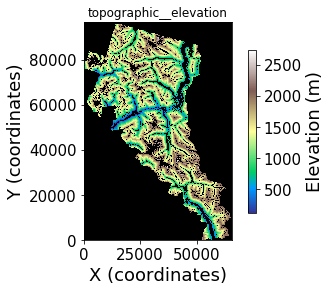

In [28]:
plt.figure('Elevations from the DEM [m]')
imshow_grid_at_node(grid, 'topographic__elevation', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'),
                 shrink=0.75, var_name='Elevation', var_units='m')
#plt.savefig('NOCA_elevation.png')

Excluded areas from the analysis are shown in black, including outside the park and inside the park areas that are water bodies, snow, glaciers, wetlands, exposed bedrock, and slopes <= 17 degrees. 

Plot slope overlaid with mapped landslide types. Takes about a few minutes.

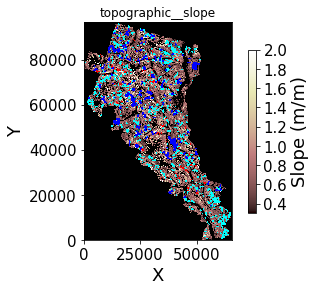

In [29]:
plt.figure('Landslides')
ls_mask1 = grid.at_node['landslides'] != 1.0
ls_mask2 = grid.at_node['landslides'] != 2.0
ls_mask3 = grid.at_node['landslides'] != 3.0
ls_mask4 = grid.at_node['landslides'] != 4.0
overlay_landslide1 = np.ma.array(grid.at_node['landslides'], mask=ls_mask1)
overlay_landslide2 = np.ma.array(grid.at_node['landslides'], mask=ls_mask2)
overlay_landslide3 = np.ma.array(grid.at_node['landslides'], mask=ls_mask3)
overlay_landslide4 = np.ma.array(grid.at_node['landslides'], mask=ls_mask4)
imshow_grid_at_node(grid, 'topographic__slope', cmap='pink',
                 grid_units=('coordinates', 'coordinates'), vmax=2.,
                 shrink=0.75, var_name='Slope', var_units='m/m')
imshow_grid_at_node(grid, overlay_landslide1, color_for_closed='None',
                 allow_colorbar=False, cmap='cool')
imshow_grid_at_node(grid, overlay_landslide2, color_for_closed='None',
                 allow_colorbar=False, cmap='autumn')
imshow_grid_at_node(grid, overlay_landslide3, color_for_closed='None',
                 allow_colorbar=False, cmap='winter')
imshow_grid_at_node(grid, overlay_landslide4, color_for_closed='None',
                 allow_colorbar=False,cmap='summer')
#plt.savefig('NOCA_Landslides_on_Slope.png')

Legend to mapped landslides: blue - debris avalanches, cyan - falls/topples, red - debris torrents, and green - slumps/creeps

Plot of soil depth (m)

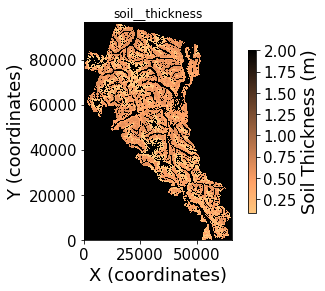

In [30]:
plt.figure('Soil Thickness')
imshow_grid_at_node(grid, 'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')
#plt.savefig('NOCA_SoilDepth.png')

Plot probability of saturation 

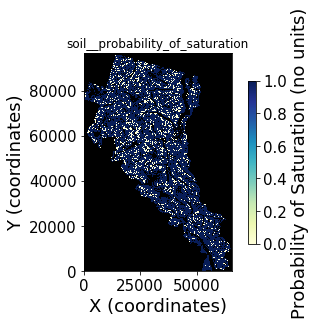

In [31]:
plt.figure('Probability of Saturation')
imshow_grid_at_node(grid, 'soil__probability_of_saturation', cmap='YlGnBu',
                 limits=((0), (1)),
                 grid_units=('coordinates', 'coordinates'),
                 shrink=0.75, var_name='Probability of Saturation',
                 var_units='no units')
#plt.savefig('NOCA_ProbabilityofSaturation.png')

This map shows the probability of saturation as high throughout much of the area because we modeled the annual maximum recharge, which is esssentially the worst case conditions that might lead to instability.

Plot probability of failure; Compare this with the elevation and slope maps.

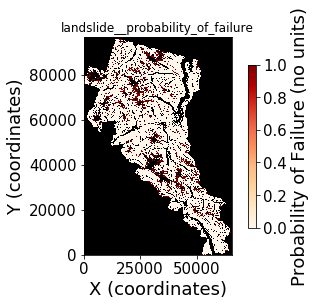

In [32]:
plt.figure('Probability of Failure')
imshow_grid_at_node(grid, 'landslide__probability_of_failure', cmap='OrRd',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Probability of Failure', var_units='no units')
#plt.savefig('NOCA_ProbabilityofFailure.png')

The map of probability of failure shows higher probabilities at higher elevations below retreating glaciers where vegation is sparse and shallow unconsolidated sediment is prevalent.

To review the fields assigned to the grid, simply execute the following command.

In [33]:
grid.at_node

{'exclusion_mask': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'landslide__probability_of_failure': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'landslides': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__density': array([ 2000.,  2000.,  2000., ...,  2000.,  2000.,  2000.]),
 'soil__internal_friction_angle': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__maximum_total_cohesion': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__mean_relative_wetness': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'soil__minimum_total_cohesion': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__mode_total_cohesion': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__probability_of_saturation': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__saturated_hydraulic_conductivity': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'soil__thickness': array([-9999., -9999.

Export data from model run: FS probability, mean Reletive wetness, probability of saturation

In [34]:
import pandas as pd
core_nodes = grid.core_nodes
data_extracted = {'PF_3S_SD': np.array(
                 grid.at_node['landslide__probability_of_failure'][grid.core_nodes]),
                 'mean_RW': np.array(grid.at_node['soil__mean_relative_wetness']
                 [grid.core_nodes]),'prob_sat': np.array(
                 grid.at_node['soil__probability_of_saturation'][grid.core_nodes])}
headers = ['PF_3S_SD','mean_RW','prob_sat']
df = pd.DataFrame(data_extracted, index=core_nodes, columns=(headers))
df.to_csv('FS3k_SSD_demo.csv')

Make ascii files for raster creation in GIS

In [35]:
write_esri_ascii('prbF_3kSSD_demo.txt',grid,names='landslide__probability_of_failure')
write_esri_ascii('mRW_3kSSD_demo.txt',grid,names='soil__mean_relative_wetness')
write_esri_ascii('prbSat_3kSSD_demo.txt',grid,names='soil__probability_of_saturation')

['prbSat_3kSSD_demo.txt']